## Имеет ли смысл обучать свои эмбеддинги?

## Предобученные русскоязычные эмбеддинги

### RusVectores

[RusVectōrēs](https://rusvectores.org/ru/): семантические модели для русского языка

In [ ]:
import urllib.request
import gensim

In [ ]:
urllib.request.urlretrieve(
    "https://rusvectores.org/static/models/rusvectores4/ruwikiruscorpora/ruwikiruscorpora_upos_skipgram_300_2_2018.vec.gz", 
    "ruwikiruscorpora_upos_skipgram_300_2_2018.vec.gz"
)

('ruwikiruscorpora_upos_skipgram_300_2_2018.vec.gz',
 <http.client.HTTPMessage at 0x7fb060d06220>)

In [ ]:
model_path = 'ruwikiruscorpora_upos_skipgram_300_2_2018.vec.gz'
model_ru = gensim.models.KeyedVectors.load_word2vec_format(model_path)

In [ ]:
model_ru.most_similar(positive=['ночь_NOUN'], topn=10)

[('ночь_PROPN', 0.7704508304595947),
 ('вечер_NOUN', 0.7683228254318237),
 ('утро_NOUN', 0.7520124316215515),
 ('полночь_NOUN', 0.7201331853866577),
 ('рассвет_NOUN', 0.6792924404144287),
 ('полдень_NOUN', 0.6637035012245178),
 ('утро_PROPN', 0.6531521677970886),
 ('ночь_ADV', 0.6248846650123596),
 ('сумерки_NOUN', 0.6227153539657593),
 ('ночью_NOUN', 0.6219336986541748)]

#### Проблемы

- На практике использовать такие эмбеддинги неудобно. Недостаточно разделить текст на токены, для каждого нужно как-то определить POS-тег. 

- Таблица эмбеддингов разбухает. Вместо одного слова «стать», мы храним 6: 2 разумных «стать_VERB», «стать_NOUN» и 4 странных «стать_ADV», «стать_PROPN», «стать_NUM», «стать_ADJ». 

- В таблице на 250 000 записей 195 000 уникальных слов.

### Navec

[navec](https://natasha.github.io/navec/) - компактные эмбеддинги для русского языка

GloVe эмбеддинги, в текстах мало опечаток, проблему OOV-токенов решает большой словарь. 250 000 строк в таблице news_1B_250K_300d_100q покрывают 98% слов в новостных статьях.

Архивы мало весят из-за квантизации: заменили 32-битные float-числа на 8-битные коды, затем заменили int-кодом не одно, а 3 числа. Кластеризуем все тройки чисел из таблицы эмбеддингов алгоритмом k-means на 256 кластеров, вместо каждой тройки будем хранить код от 0 до 255. 

При использовании сжатые вектора распаковываются


[Navec evaluation](https://github.com/natasha/navec#evaluation)

In [ ]:
!pip install navec

In [ ]:
!wget https://storage.yandexcloud.net/natasha-navec/packs/navec_news_v1_1B_250K_300d_100q.tar

In [ ]:
from navec import Navec

In [ ]:
path = 'navec_news_v1_1B_250K_300d_100q.tar'
navec = Navec.load(path)
navec['человек'][:15]

array([-0.13068067, -0.12051002, -0.05782367,  0.07967507,  0.08338855,
        0.59920526,  0.4020081 , -1.0838276 ,  0.12556174,  0.17060532,
        0.16637331, -0.00257014,  0.51296437,  0.17175263, -0.40394753],
      dtype=float32)

## Оценка близости векторов

- существует много разных способов измерить расстояние между векторами
- но в NLP мы чаще всего сталкиваемся с косинусным расстоянием

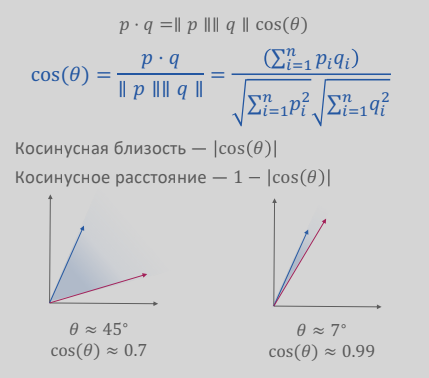

Длина вектора может зависеть от модели, которой этот вектор был построен. Тогда, например, Евклидово расстояние будет большим, но с косинусным все хорошо

## Визуализация

https://projector.tensorflow.org/

## Оценка эмбеддингов

### Intrinsic

#### SimLex-999

[SimLex-999](https://fh295.github.io/simlex.html) 

Обеспечивает способ измерения того, насколько хорошо модели отражают сходство, а не родство или ассоциацию.

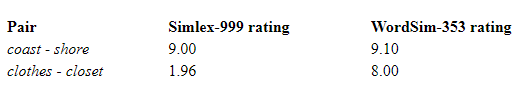

(coast\shore - берег, closet - шкаф, clothes - одежда)

#### wordsim353

[wordsim353](http://alfonseca.org/eng/research/wordsim353.html)

Оценивает сходство/связность слов

## Doc2Vec

[gensim Doc2Vec](https://radimrehurek.com/gensim/models/doc2vec.html)

In [ ]:
!wget https://github.com/yutkin/Lenta.Ru-News-Dataset/releases/download/v1.0/lenta-ru-news.csv.gz

In [ ]:
!pip install corus

In [ ]:
from gensim.models.doc2vec import TaggedDocument, Doc2Vec
from corus import load_lenta
import spacy

In [ ]:
path = 'lenta-ru-news.csv.gz'
records = load_lenta(path)
data = [next(records).text for i in range(10000)]

In [ ]:
#prepare dataset
def create_tagged_document(list_of_list_of_words):
    for i, list_of_words in enumerate(list_of_list_of_words):
        yield TaggedDocument(list_of_words, [i])

train_data = list(create_tagged_document(data))
print(train_data[:1])

[TaggedDocument(words='Вице-премьер по социальным вопросам Татьяна Голикова рассказала, в каких регионах России зафиксирована наиболее высокая смертность от рака, сообщает РИА Новости. По словам Голиковой, чаще всего онкологические заболевания становились причиной смерти в Псковской, Тверской, Тульской и Орловской областях, а также в Севастополе. Вице-премьер напомнила, что главные факторы смертности в России — рак и болезни системы кровообращения. В начале года стало известно, что смертность от онкологических заболеваний среди россиян снизилась впервые за три года. По данным Росстата, в 2017 году от рака умерли 289 тысяч человек. Это на 3,5 процента меньше, чем годом ранее.', tags=[0])]


In [ ]:
%%time

model = Doc2Vec(vector_size=50, min_count=1, epochs=40)
model.build_vocab(train_data)
model.train(train_data, total_examples=model.corpus_count, epochs=model.epochs)

CPU times: user 9min 46s, sys: 11.1 s, total: 9min 57s
Wall time: 6min 24s


In [ ]:
print(model.infer_vector('Вице-премьер по социальным вопросам Татьяна Голикова рассказала...'.split(' ')))

[-4.7203694e-03 -5.5024968e-03  4.4733179e-03  4.7838686e-05
  3.0523217e-03 -7.8172358e-03 -3.9171646e-03 -5.9685705e-04
  1.2103665e-03 -6.8730628e-03 -2.3947072e-03  4.3763043e-04
  7.2891354e-03  4.7484841e-03 -2.9249173e-03 -3.3222050e-03
 -3.8177555e-03 -7.2721182e-04  3.7145496e-03  8.1716208e-03
  3.1515884e-03  5.3341375e-03  6.9687343e-03  7.1082162e-03
  9.4214194e-03 -9.3498426e-03  3.0069791e-03  6.0512065e-03
 -2.7917945e-03 -1.5982210e-03  4.4865217e-03  7.7362941e-03
 -5.3791534e-03 -8.3851200e-03 -9.7940862e-04 -2.7725452e-03
  4.6101380e-03  2.3691535e-03 -9.1227057e-04 -9.8531721e-03
  9.5840935e-03 -3.6485964e-03 -6.2402799e-03 -1.0192364e-03
  9.9339371e-04  5.4243091e-04  8.7311509e-04  1.7242730e-03
  4.7846435e-04  1.8223620e-03]
